Check that GPU acceleration is available

In [1]:
import torch
torch.cuda.is_available()

True

Allow for module import without package installation

In [3]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

Check the data train, test and validation splits

In [5]:
from datasets import OrganoidDataset
data = OrganoidDataset(data_dir='../data/organoids')

In [6]:
print(data.train[0].shape,data.train[1].shape)
print(data.val[0].shape,data.val[1].shape)
print(data.test[0].shape,data.test[1].shape)

(820733, 41) (820733, 3)
(234495, 41) (234495, 3)
(117248, 41) (117248, 3)


In [10]:
data.train[0][:10,]

array([[0.        , 4.104063  , 3.523024  , 0.        , 2.8842375 ,
        1.9796327 , 1.5425261 , 0.21254665, 5.108574  , 2.0377157 ,
        2.758132  , 1.9190588 , 3.0157628 , 3.4956138 , 1.8469115 ,
        1.6885663 , 2.951822  , 0.6304968 , 0.1266906 , 2.728949  ,
        1.5509099 , 3.1144717 , 1.8906862 , 3.8098633 , 3.0679593 ,
        1.4153538 , 2.5113766 , 4.0736837 , 3.041937  , 1.7411104 ,
        3.2478619 , 3.4531243 , 0.        , 2.963743  , 0.        ,
        2.7369626 , 1.7848017 , 0.1497951 , 0.        , 3.8881786 ,
        6.389593  ],
       [0.        , 3.2745147 , 1.7237808 , 0.        , 2.1001139 ,
        1.7389098 , 0.26420817, 0.        , 0.        , 1.3939728 ,
        2.4651933 , 2.581652  , 2.1718793 , 2.692238  , 1.1822753 ,
        0.4871497 , 2.8761194 , 0.02527835, 1.2227291 , 2.6821272 ,
        0.7057958 , 3.5075676 , 2.5523038 , 2.6398144 , 1.154751  ,
        2.9314353 , 1.7495167 , 4.225674  , 1.8345497 , 0.08797868,
        2.7951415 , 0.06220

In [13]:
data.train[1].head(10)

,index,cell_type,day
0,156737,Enterocyte,2
1,1151315,Tuft,7
2,611947,Enteroendocrine,3
3,756795,Goblet,6
4,213350,Enterocyte,2
5,971558,Stem,6
6,557514,Enterocyte,7
7,130855,Enterocyte,2
8,680015,Enteroendocrine,6
9,410656,Enterocyte,4


Load the default model and the default config for this model. It contains all parameters needed for a standalone run, so some of them are not needed in this notebook.

In [15]:
from models import BetaVAE
from configs.beta_vae import get_config

config = get_config()
config

activation: LeakyReLU
batch_size: 4096
dataset: Organoid
device: cuda
epochs: 10000
hidden_dims: !!python/tuple
- 32
- 32
- 32
in_features: 41
kld_weight: 0.0025
latent_dim: 2
learning_rate: 0.05
loss_type: beta
max_grad_norm: .inf
model: VAE
output_dir: ./logs/VanillaVAE/
save_loss_every_n_epochs: 10
seed: 12345
weight_decay: 0.0

Create a NN and move it to the GPU

In [16]:
model = BetaVAE(config).to('cuda')

Set up data loader for the training set, and load validation set. Validation set will be processed at once for simplicity.

In [24]:
from torch.utils.data import TensorDataset, DataLoader

X_train,y_train = data.train
X_val,y_val = data.val

X_train_ds = TensorDataset(torch.tensor(X_train))

X_train_dl = DataLoader(X_train, batch_size=32*2**10, drop_last=True, pin_memory=True)

Set up a standard optimizer

In [18]:
from torch import optim

optimizer = optim.Adam(model.parameters(),lr=0.005)

Run the neural network training for 101 epochs, print metrics on validation set every 10 epochs.
Training should take less than 10 minutes on GPU.

In [30]:
from tqdm import tqdm

pbar = tqdm(range(101))

for epoch in pbar:
    for X_batch in X_train_dl:
        optimizer.zero_grad()
        outputs = model.forward(X_batch.to('cuda'))
        loss = model.loss_function(*outputs)['loss']
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            outputs = model.forward(torch.tensor(X_val, device='cuda'))
            loss = model.loss_function(*outputs)

            pbar.set_description(f"Epoch: {epoch+1}, "
                             f"Loss: {loss['loss'].detach().item()}, "
                             f"MSE: {loss['MSE']}, "
                             f"KLD: {loss['KLD']}", refresh=True)

print('Finished Training')

Epoch: 101, Loss: 0.41594594717025757, MSE: 0.3975306749343872, KLD: -7.366103172302246: 100%|██████████| 101/101 [03:36<00:00,  2.15s/it]

Finished Training


# Latent space visualizations

In [41]:
import pandas as pd
with torch.no_grad():
    latent_val = model.latent(torch.tensor(X_val, device='cuda')).cpu().numpy()
latent_df = pd.DataFrame(latent_val, columns=["VAE1","VAE2"])

metadata = y_val

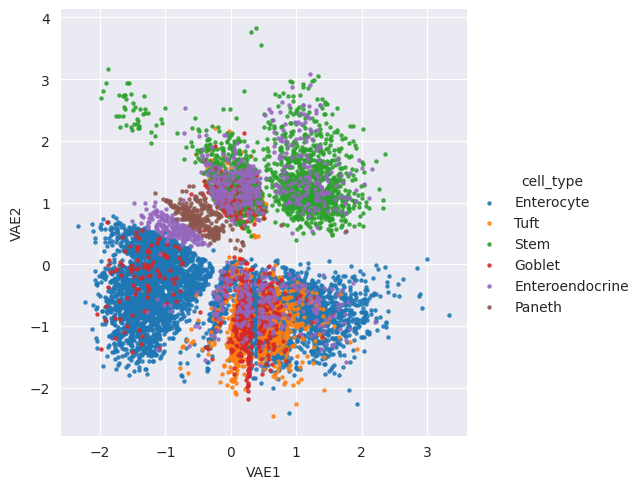

In [38]:
import seaborn as sns

sns.lmplot(x="VAE1", y="VAE2",
           data=pd.concat([latent_df, metadata], axis=1).head(10000),
           fit_reg=False,
           hue='cell_type',
           legend=True,
           scatter_kws={"s": 5})

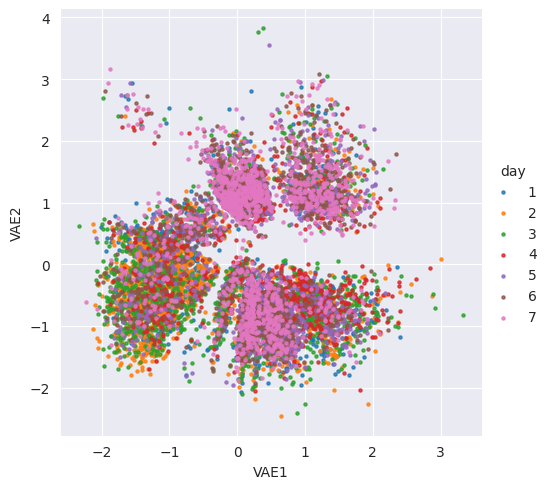

In [40]:
sns.lmplot(x="VAE1", y="VAE2",
           data=pd.concat([latent_df, metadata], axis=1).head(10000),
           fit_reg=False,
           hue='day',
           legend=True,
           scatter_kws={"s": 5})